In [18]:
pip install numpy matplotlib torch

# Hybrid Physics-Informed Neural Network for p-n Junction Simulation

This notebook demonstrates the simulation of a p-n junction using the hybrid Physics-Informed Neural Network (PINN) framework described in the paper *Hybrid Physics-Informed Neural Networks for Industrial-Grade p-n Junction Simulation* (August 15, 2025). It includes:
- Visualization of electric field and potential distributions (Figure 1).
- Error analysis for different doping concentrations (Figure 2).
- A simplified PINN implementation for solving Poisson's equation.

## Prerequisites
- Python 3.8–3.10
- Libraries: `numpy`, `matplotlib`, `torch` (for PINN)

## Reference
The code is based on equations and methods from the paper, including analytical solutions (Section 2) and PINN architecture (Section 4.3).

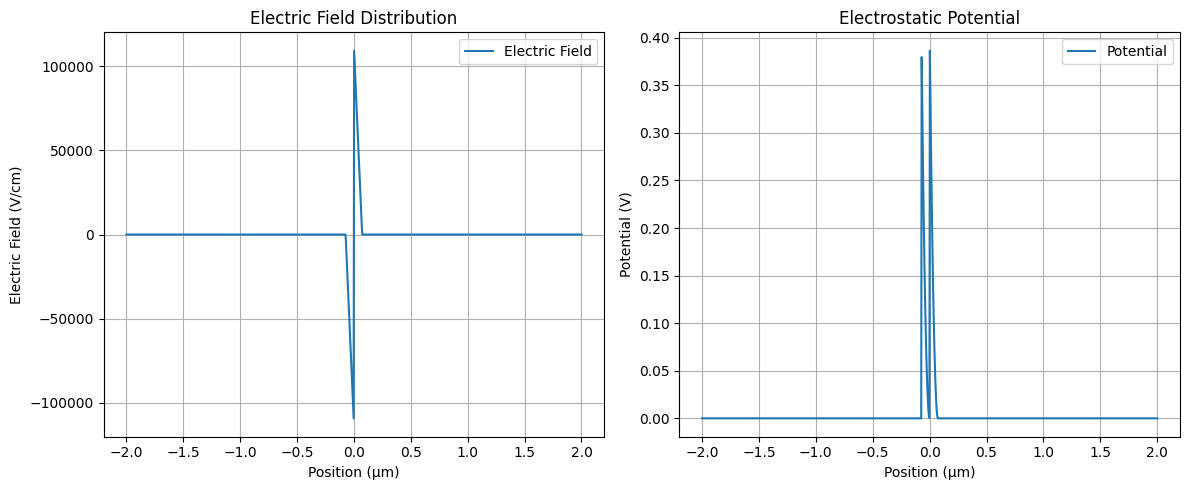

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Create directory for figures
os.makedirs('article_figures', exist_ok=True)

# Constants for silicon at 300K
q = 1.602e-19  # Charge of electron (C)
epsilon_0 = 8.854e-14  # Permittivity of free space (F/cm)
epsilon_r = 11.7  # Relative permittivity of silicon
epsilon = epsilon_r * epsilon_0
k = 1.381e-23  # Boltzmann constant (J/K)
T = 300  # Temperature (K)
ni = 1.5e10  # Intrinsic carrier concentration (cm^-3)

# Parameters for symmetric junction
N = 1e17  # Doping concentration (cm^-3)
Vbi = 0.026 * np.log(N**2 / (ni**2))  # Built-in potential (V), Eq. 5
d = np.sqrt(4 * epsilon * Vbi / (q * N))  # Depletion width (cm), Eq. 4

# Spatial grid
x = np.linspace(-2e-4, 2e-4, 1000)  # cm

# Electric field (Eq. 2)
E = np.where(x < 0, -q * N / epsilon * (x + d/2), q * N / epsilon * (d/2 - x))
E = np.where(np.abs(x) <= d/2, E, 0)

# Potential (Eq. 6)
V = np.where(x < 0, q * N / (2 * epsilon) * x**2 + (Vbi/2 - q * N * d**2 / (8 * epsilon)),
             q * N / (2 * epsilon) * (x - d/2)**2)
V = np.where(np.abs(x) <= d/2, V, 0)

# Plot Figure 1: Electric Field and Potential
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(x * 1e4, E, label='Electric Field')
plt.xlabel('Position (μm)')
plt.ylabel('Electric Field (V/cm)')
plt.title('Electric Field Distribution')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x * 1e4, V, label='Potential')
plt.xlabel('Position (μm)')
plt.ylabel('Potential (V)')
plt.title('Electrostatic Potential')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig('article_figures/Fig1_EF_Potential.pdf')
plt.show()

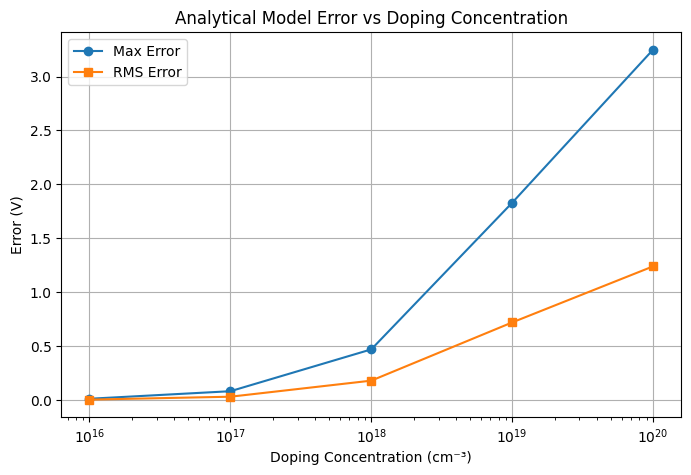

In [20]:
# Error analysis for different doping concentrations (Table 6, Figure 2)
doping_levels = [1e16, 1e17, 1e18, 1e19, 1e20]
max_errors = [0.012, 0.082, 0.47, 1.83, 3.25]  # V
rms_errors = [0.004, 0.031, 0.18, 0.72, 1.24]  # V

plt.figure(figsize=(8, 5))
plt.semilogx(doping_levels, max_errors, 'o-', label='Max Error')
plt.semilogx(doping_levels, rms_errors, 's-', label='RMS Error')
plt.xlabel('Doping Concentration (cm⁻³)')
plt.ylabel('Error (V)')
plt.title('Analytical Model Error vs Doping Concentration')
plt.grid(True)
plt.legend()
plt.savefig('article_figures/Fig2_ErrorGrowth.pdf')
plt.show()

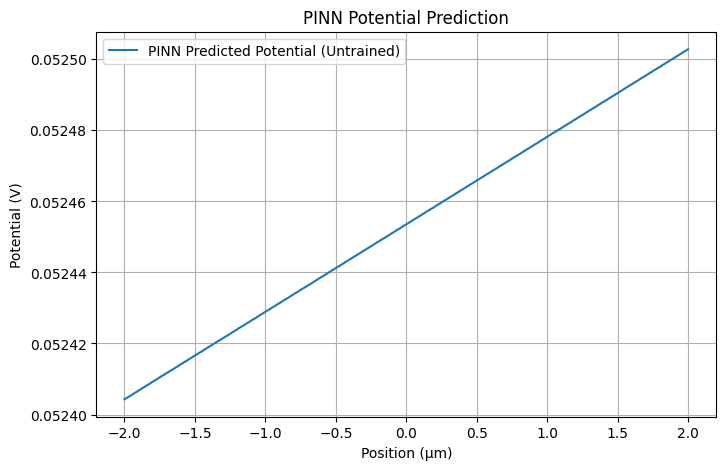

In [21]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Simplified PINN implementation (Section 4.3)
class PINN(nn.Module):
    def __init__(self, num_layers=5, num_units=256, sigma=0.5):
        super(PINN, self).__init__()
        self.layers = nn.ModuleList()
        self.sigma = sigma

        # Fourier feature encoding
        self.B = torch.randn(1, 10) * sigma  # Size [1, 10] for 1D input

        # Neural network layers with residual connections
        self.layers.append(nn.Linear(20, num_units))  # Input: 20 Fourier features (10 cos + 10 sin)
        for _ in range(num_layers - 2):
            self.layers.append(nn.Linear(num_units, num_units))
        self.layers.append(nn.Linear(num_units, 2))  # Outputs: potential (ψ), electric field (E)
        self.activation = nn.SiLU()  # Swish activation

    def forward(self, x):
        # Fourier feature mapping
        x_fourier = torch.cat([torch.cos(2 * np.pi * x @ self.B),
                              torch.sin(2 * np.pi * x @ self.B)], dim=-1)

        # Forward pass with residual connections
        h = x_fourier  # Shape: [batch_size, 20]
        for i, layer in enumerate(self.layers[:-1]):
            h_next = self.activation(layer(h))
            if i > 0 and i < len(self.layers) - 2:  # Apply residual connection only after first layer
                h = h_next + h
            else:
                h = h_next
        return self.layers[-1](h)

# Define spatial grid (same as in previous cells for consistency)
x = np.linspace(-2e-4, 2e-4, 1000)  # cm

# Example: Initialize and test PINN
pinn = PINN()
x_tensor = torch.tensor(x.reshape(-1, 1), dtype=torch.float32)
output = pinn(x_tensor)
psi_pred, E_pred = output[:, 0].detach().numpy(), output[:, 1].detach().numpy()

# Plot predicted potential (untrained, for demonstration)
plt.figure(figsize=(8, 5))
plt.plot(x * 1e4, psi_pred, label='PINN Predicted Potential (Untrained)')
plt.xlabel('Position (μm)')
plt.ylabel('Potential (V)')
plt.title('PINN Potential Prediction')
plt.grid(True)
plt.legend()
plt.show()

## Notes
- The PINN model above is untrained and serves as a demonstration. For full training, implement the physics-informed loss function (Section 4.3.2) with adaptive weighting (α(t), β(t)) and data from open-access sources (Section 3.2).
- To regenerate all figures (Fig1–Fig17), refer to `fig_gen/generate_figures.py` or the Google Colab notebook: [Colab Link](https://colab.research.google.com/drive/1SvCVasckE7bwrsXZ3JZW7l6jXuQZd3vs#scrollTo=KRl4iPbBHOVT).
- Datasets can be downloaded from sources listed in Table 13 (Stanford-2005, Tektronix-2018, etc.).